This jupyter notebook does the cleaning, preprocessing and annotation of the OTU table obtained from the TotalRNA pipeline after aligning the mRNA to the NCyc database using SWORD. 

This notebook relies in the previous CoMW script and it is coupled to a specific version of the database. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import roman

## Read SWORD file
Our input is a bm9 file, which is not exactly a csv file. The easiest way to read it as a CSV file is to create a temporary file. 

In [2]:
aligned_bm9 = '../results/mRNA/sword/SWORD_NCyc_result.bm9'
!head ../results/mRNA/sword/SWORD_NCyc_result.bm9

# Fields:
Query id,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
TRINITY_DN13529_c0_g1_i4_6	9823.ENSSSCP00000021891	25	444	248	24	1627	2026	734	1138	1.37e-04	129
TRINITY_DN13529_c0_g1_i4_6	a22da23d89938f0d98c5f6b7eb52f002	29	121	67	5	1236	1349	519	627	0.73	93
TRINITY_DN13529_c0_g1_i4_6	98b49a5c5a026c9ec3fe6007645fc5c7	25	301	180	14	34	307	435	717	1.57	90
TRINITY_DN13529_c0_g1_i4_6	875328.JDM601_0563	25	102	72	2	2368	2466	132	232	3.58	86
TRINITY_DN13529_c0_g1_i4_6	645465.SSTG_00793	27	142	81	6	173	311	1278	1400	3.78	87
TRINITY_DN13529_c0_g1_i4_6	F2U7J5	23	383	216	18	1717	2070	164	495	4.53	86
TRINITY_DN13529_c0_g1_i4_6	dec236df31b3dbbf702946d3ca595132	21	294	172	10	1833	2087	416	687	5.40	85
# Fields:


In [3]:
%%bash
grep -v "Query id," < ../results/mRNA/sword/SWORD_NCyc_result.bm9 >  temp_SWORD_NCyc_result.csv

In [4]:
sword = pd.read_csv(
    'temp_SWORD_NCyc_result.csv',delimiter='\t',comment='#', header=None,
    names= ['Query id', 'Subject id', '% identity', 'alignment length', 
             'mismatches','gap openings','q. start', 'q. end',
             's. start', 's. end', 'e-value', 'score'
            ]
)

In [5]:
%%bash
rm  temp_SWORD_NCyc_result.csv

Now, we have a table with all the alignments between our "genes" and the database.

In [6]:
sword

,Query id,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
0,TRINITY_DN13529_c0_g1_i4_6,9823.ENSSSCP00000021891,25,444,248,24,1627,2026,734,1138,0.000137,129
1,TRINITY_DN13529_c0_g1_i4_6,a22da23d89938f0d98c5f6b7eb52f002,29,121,67,5,1236,1349,519,627,0.730000,93
2,TRINITY_DN13529_c0_g1_i4_6,98b49a5c5a026c9ec3fe6007645fc5c7,25,301,180,14,34,307,435,717,1.570000,90
3,TRINITY_DN13529_c0_g1_i4_6,875328.JDM601_0563,25,102,72,2,2368,2466,132,232,3.580000,86
4,TRINITY_DN13529_c0_g1_i4_6,645465.SSTG_00793,27,142,81,6,173,311,1278,1400,3.780000,87
...,...,...,...,...,...,...,...,...,...,...,...,...
1440480,TRINITY_DN42266_c0_g1_i1_1,6cba86f194f15723324cbb01b577b3a2,37,30,19,0,23,52,679,708,6.910000,62
1440481,TRINITY_DN42266_c0_g1_i1_1,d44f9f7bbd872bbbd75cbbfbb9fabcc1,37,30,19,0,23,52,724,753,6.920000,62
1440482,TRINITY_DN42266_c0_g1_i1_1,mmc:Mmcs_3229,37,30,19,0,23,52,724,753,6.920000,62
1440483,TRINITY_DN59565_c0_g1_i1_2,0395a57d554cf9a3ca0b71397c17bd0d,37,71,34,6,3,66,640,706,5.100000,63


## Read count table
However, we also need to read the count table:

In [7]:
counts_tsv = '../results/mRNA/mapped_reads_to_contigs_AbundanceFiltered.tsv'
! head ../results/mRNA/mapped_reads_to_contigs_AbundanceFiltered.tsv

ContigID	Katie45	Katie54	Katie32	Katie25
TRINITY_DN16047_c0_g1_i1	3	0	2	2
TRINITY_DN3406_c0_g1_i2	0	37	0	4
TRINITY_DN6613_c4_g1_i2	4	18	0	0
TRINITY_DN5543_c0_g1_i2	3	0	4	3
TRINITY_DN60437_c0_g1_i1	0	10	0	1
TRINITY_DN573_c0_g1_i1	0	51	2	2
TRINITY_DN61772_c0_g1_i1	0	8	0	0
TRINITY_DN15263_c0_g1_i1	0	7	0	2
TRINITY_DN2319_c0_g1_i9	48	0	8	27


In [8]:
counts = pd.read_csv(
    counts_tsv, sep = "\t", comment='#'
).set_index('ContigID')
counts

,Katie45,Katie54,Katie32,Katie25
ContigID,,,,
TRINITY_DN16047_c0_g1_i1,3,0,2,2
TRINITY_DN3406_c0_g1_i2,0,37,0,4
TRINITY_DN6613_c4_g1_i2,4,18,0,0
TRINITY_DN5543_c0_g1_i2,3,0,4,3
TRINITY_DN60437_c0_g1_i1,0,10,0,1
...,...,...,...,...
TRINITY_DN48454_c0_g1_i1,4,0,4,2
TRINITY_DN41188_c0_g1_i1,2,0,2,2
TRINITY_DN7932_c0_g2_i1,4,0,2,7


## Preprocessing
### Most significant hit per Contig

Before using Sword, we used transeq to obtain each possible ORF. Let's create a column with the gene name. That is, without the last 2 characters (_ 1, _ 2...) that encode the ORF.

In [9]:
sword['ContigID'] = sword['Query id'].str.replace('_[1-6]$', '', regex=True)
sword['ContigID']

0          TRINITY_DN13529_c0_g1_i4
1          TRINITY_DN13529_c0_g1_i4
2          TRINITY_DN13529_c0_g1_i4
3          TRINITY_DN13529_c0_g1_i4
4          TRINITY_DN13529_c0_g1_i4
                     ...           
1440480    TRINITY_DN42266_c0_g1_i1
1440481    TRINITY_DN42266_c0_g1_i1
1440482    TRINITY_DN42266_c0_g1_i1
1440483    TRINITY_DN59565_c0_g1_i1
1440484    TRINITY_DN19471_c0_g1_i1
Name: ContigID, Length: 1440485, dtype: object

Now, we need to get the most significant hit per each contig ID. Let's inspect how many hits there are per contig (adjust the number of bins). 

Text(0.5, 1.0, 'Number of hits per contig')

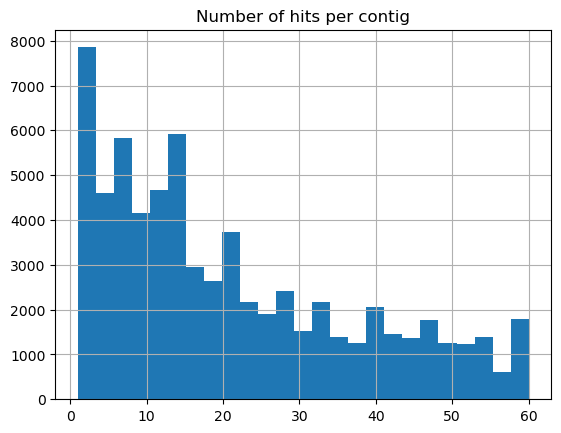

In [10]:
sword.pivot_table(columns=['ContigID'], aggfunc='size').hist(bins = 25)
plt.title("Number of hits per contig")

In this case, we are going to sort rows per e-value and score and get the most significant hit per each ContigId.

In [11]:
sword = sword.sort_values(
        by=['e-value', 'score'], ascending=[True, False]
        ).drop_duplicates(
    'ContigID', keep='first'
).set_index('ContigID')
sword

,Query id,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
ContigID,,,,,,,,,,,,
TRINITY_DN1086_c0_g2_i1,TRINITY_DN1086_c0_g2_i1_3,vcn:VOLCADRAFT_75431,89,907,97,3,32,938,16,915,0.00,4017
TRINITY_DN1086_c0_g2_i3,TRINITY_DN1086_c0_g2_i3_3,vcn:VOLCADRAFT_75431,88,907,100,3,32,938,16,915,0.00,3994
TRINITY_DN3675_c0_g1_i2,TRINITY_DN3675_c0_g1_i2_3,391612.CY0110_24021,81,872,165,1,27,898,1,871,0.00,3614
TRINITY_DN3675_c0_g1_i5,TRINITY_DN3675_c0_g1_i5_3,391612.CY0110_24021,81,872,166,1,27,898,1,871,0.00,3611
TRINITY_DN3675_c0_g1_i4,TRINITY_DN3675_c0_g1_i4_3,391612.CY0110_24021,81,838,157,0,27,864,1,838,0.00,3500
...,...,...,...,...,...,...,...,...,...,...,...,...
TRINITY_DN39702_c0_g1_i1,TRINITY_DN39702_c0_g1_i1_4,9391952782dd27c9653359445c5004b4,31,51,26,2,21,67,982,1027,9.99,61
TRINITY_DN49433_c0_g1_i1,TRINITY_DN49433_c0_g1_i1_1,d3aad35ad3781983eec60d4d6c0cbef4,35,55,30,3,20,72,16,66,9.99,60
TRINITY_DN35066_c0_g1_i1,TRINITY_DN35066_c0_g1_i1_1,426418.XP_001938893.1,45,22,12,0,19,40,155,176,9.99,60


### Inspect E-values from aligned orthologous genes before filtering by e-value

array([[<Axes: title={'center': 'e-value'}>]], dtype=object)

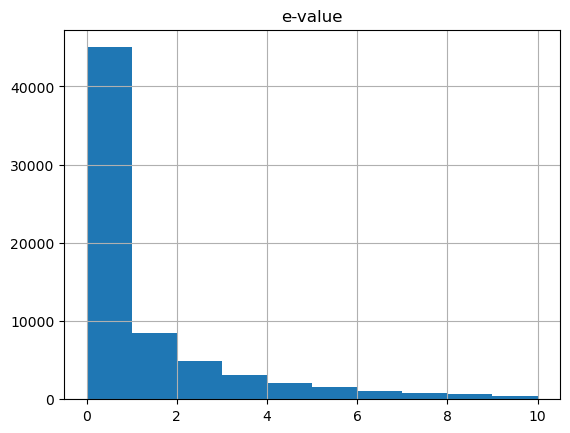

In [12]:
sword.hist("e-value")

### Inspect E-values from aligned orthologous genes after filtering by e-value

We need to set a threshold:

In [13]:
evalue_threshold = 0.001

In [14]:
sword = sword.loc[sword['e-value'] < evalue_threshold] 

array([[<Axes: title={'center': 'e-value'}>]], dtype=object)

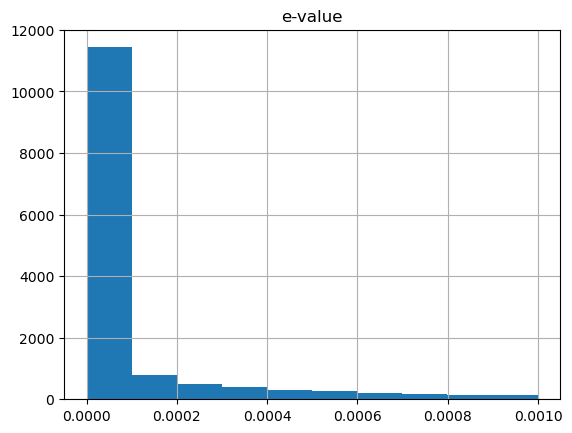

In [15]:
sword.hist("e-value")

In [16]:
val = len(set(sword["Subject id"]))
print(f"There are {val} unique orthologous genes")

There are 2632 unique orthologous genes


### Inspect % identity and aligment length

array([[<Axes: title={'center': 'alignment length'}>]], dtype=object)

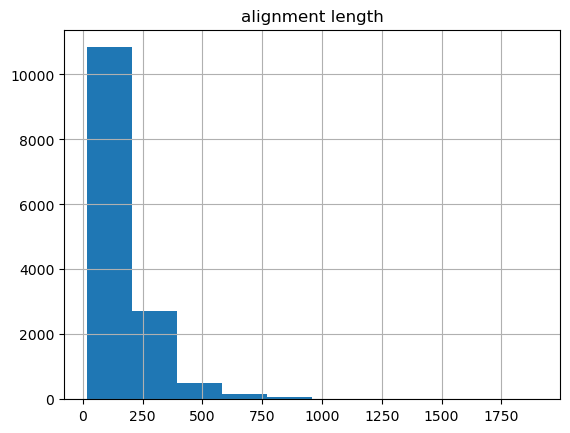

In [17]:
sword.hist("alignment length")

array([[<Axes: title={'center': '% identity'}>]], dtype=object)

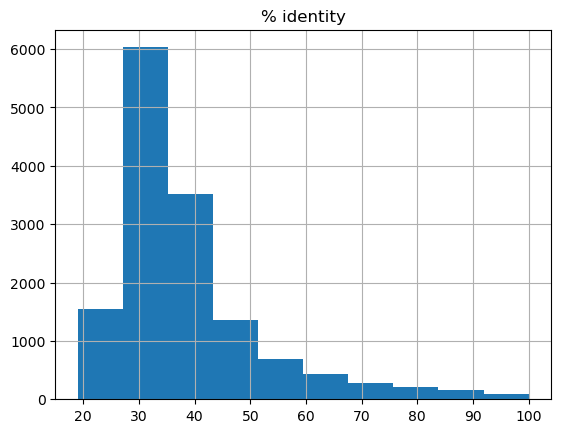

In [18]:
sword.hist("% identity")

### Merging aligned genes and count table
First, we are going to drop all columns except for ContigsID and orthologous genes header (to obtain map table). 

In [19]:
map_table = sword[["Query id","Subject id"]]
map_table

,Query id,Subject id
ContigID,,
TRINITY_DN1086_c0_g2_i1,TRINITY_DN1086_c0_g2_i1_3,vcn:VOLCADRAFT_75431
TRINITY_DN1086_c0_g2_i3,TRINITY_DN1086_c0_g2_i3_3,vcn:VOLCADRAFT_75431
TRINITY_DN3675_c0_g1_i2,TRINITY_DN3675_c0_g1_i2_3,391612.CY0110_24021
TRINITY_DN3675_c0_g1_i5,TRINITY_DN3675_c0_g1_i5_3,391612.CY0110_24021
TRINITY_DN3675_c0_g1_i4,TRINITY_DN3675_c0_g1_i4_3,391612.CY0110_24021
...,...,...
TRINITY_DN22093_c0_g1_i1,TRINITY_DN22093_c0_g1_i1_1,f233956ed8575298e9ff9caf1464a4db
TRINITY_DN39496_c0_g1_i1,TRINITY_DN39496_c0_g1_i1_1,3d82fe7d8eb346ee0eda112349852405
TRINITY_DN10688_c0_g1_i2,TRINITY_DN10688_c0_g1_i2_6,ec1224ca7e265fed2b3b9a0748be6846


Now, we are going to merge both files by their column in common (ContigID and Subject id).

In [20]:
df = pd.merge(map_table, counts, left_index=True, right_index=True).reset_index(drop=True)
df

,Query id,Subject id,Katie45,Katie54,Katie32,Katie25
0,TRINITY_DN1086_c0_g2_i1_3,vcn:VOLCADRAFT_75431,71,0,95,136
1,TRINITY_DN1086_c0_g2_i3_3,vcn:VOLCADRAFT_75431,45,0,83,92
2,TRINITY_DN3675_c0_g1_i2_3,391612.CY0110_24021,2,126,1,12
3,TRINITY_DN3675_c0_g1_i5_3,391612.CY0110_24021,2,131,1,13
4,TRINITY_DN3675_c0_g1_i4_3,391612.CY0110_24021,0,107,0,9
...,...,...,...,...,...,...
12503,TRINITY_DN604_c0_g1_i15_3,9823.ENSSSCP00000021891,4,0,30,4
12504,TRINITY_DN32561_c0_g1_i1_3,9823.ENSSSCP00000021891,4,0,0,0
12505,TRINITY_DN22093_c0_g1_i1_1,f233956ed8575298e9ff9caf1464a4db,3,0,0,6
12506,TRINITY_DN3743_c0_g1_i3_4,A0A219A4P5,8,0,22,14


### Aggregate table
Now, we are going to aggregate the rows by grouping by "Subject id" (notice the difference in rows between the previous table and the following):

In [21]:
df = df.groupby('Subject id').sum(numeric_only = True)
df

,Katie45,Katie54,Katie32,Katie25
Subject id,,,,
000c5cb581b23dd6ec6800a283686cb5,1,8,6,4
01887075f0fb3a1a0ce0e06eec2ab56e,200,0,93,106
0216cf6e6d0f13eb012abfa3e4d17136,9,379,3,34
02436ffd2ec6bf840dea76058cf189b4,25,6,12,45
028d22600fc80765c6ff0acc035efe59,0,7,2,2
...,...,...,...,...
vcn:VOLCADRAFT_76730,6,0,2,2
xal:XALc_2831,4,0,0,2
xla:380261,4,36,10,3


## Annotating count table

The original annotation involves several files, and it's intricate. We will use the original script since the effort of rewriting it for an out-of-date database doesn't seem worthy. 

In [22]:
df.reset_index(inplace=True)
df.rename(columns={"Subject id": "ContigID"}, inplace=True)
df.to_csv('NCyC_temp_count_table.tsv', sep="\t", index=False)
df

,ContigID,Katie45,Katie54,Katie32,Katie25
0,000c5cb581b23dd6ec6800a283686cb5,1,8,6,4
1,01887075f0fb3a1a0ce0e06eec2ab56e,200,0,93,106
2,0216cf6e6d0f13eb012abfa3e4d17136,9,379,3,34
3,02436ffd2ec6bf840dea76058cf189b4,25,6,12,45
4,028d22600fc80765c6ff0acc035efe59,0,7,2,2
...,...,...,...,...,...
2210,vcn:VOLCADRAFT_76730,6,0,2,2
2211,xal:XALc_2831,4,0,0,2
2212,xla:380261,4,36,10,3
2213,zma:100193235,6,0,0,4


In [23]:
%%bash
python3 /software/CoMW/scripts/annotate_count_table.py -i ./NCyC_temp_count_table.tsv -o ./NCyC_temp_count_table_ann.tsv -d 3
rm NCyC_temp_count_table.tsv

/software/CoMW/scripts/annotate_count_table.py:331: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if db is 1:
/software/CoMW/scripts/annotate_count_table.py:333: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif db is 2:
/software/CoMW/scripts/annotate_count_table.py:335: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif db is 3:


In [24]:
df = pd.read_csv(
    "NCyC_temp_count_table_ann.tsv", sep = "\t",
)

In [25]:
%%bash
rm NCyC_temp_count_table_ann.tsv

In [26]:
df.rename(columns={"#ContigID": "ContigID"}, inplace=True)
df

,ContigID,Katie45,Katie54,Katie32,Katie25,Functions
0,000c5cb581b23dd6ec6800a283686cb5,1,8,6,4,DB__NCyc; LevelI__Nitrogen fixation; LevelII__...
1,01887075f0fb3a1a0ce0e06eec2ab56e,200,0,93,106,DB__NCyc; LevelI__Denitrification; LevelII__na...
2,1_01887075f0fb3a1a0ce0e06eec2ab56e,200,0,93,106,DB__NCyc; LevelI__Dissimilatory nitrate reduct...
3,0216cf6e6d0f13eb012abfa3e4d17136,9,379,3,34,DB__NCyc; LevelI__Denitrification; LevelII__no...
4,02436ffd2ec6bf840dea76058cf189b4,25,6,12,45,DB__NCyc; LevelI__Denitrification; LevelII__ni...
...,...,...,...,...,...,...
2265,vcn:VOLCADRAFT_76730,6,0,2,2,DB__NCyc; LevelI__Denitrification; LevelII__ni...
2266,xal:XALc_2831,4,0,0,2,DB__NCyc; LevelI__Denitrification; LevelII__ni...
2267,xla:380261,4,36,10,3,DB__NCyc; LevelI__Denitrification; LevelII__ni...
2268,zma:100193235,6,0,0,4,DB__NCyc; LevelI__Denitrification; LevelII__no...


In [27]:
df.to_csv('NCyC_sword_annotated_count_table.tsv', sep="\t", index=False)